<a href="https://colab.research.google.com/github/ak-ghoul/Deep-Learning/blob/master/Large_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
train_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),]) # put mean & standard deviation of all three rgb channels as half

test_transforms= transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root = '/data', train = True, download = True, transform = train_transform)

testset = torchvision.datasets.CIFAR10(root = '/data', train = False, download = True, transform = test_transforms)

0it [00:00, ?it/s]

170500096it [00:06, 27808483.04it/s]                               


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, shuffle = True, batch_size = batch_size)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()  # next returns the next batch
print(images.shape)

print(images[0].shape)
print(labels[0].item())  # multi class classification 

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
2


In [0]:
def imshow(image, title):
  np_img = image.numpy() / 2 + 0.5   # converts image to numpy array
  plt.figure(figsize = (batch_size, 1))  # we could've written 4 there but writing batch size makes it more semantic n understandable
  plt.axis('off')
  plt.imshow(np.transpose(np_img, (1, 2, 0)))  # indices of x,y,z of image passed to perform transpose else rgb will appear at x. see images[0].shape
  plt.title(title)
  plt.show()

In [0]:
def batch_images(dataloader):
  images, labels = iter(dataloader).next()
  imgs = torchvision.utils.make_grid(images)
  imshow(imgs, [str(x.item()) for x in labels])

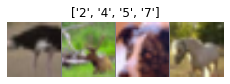

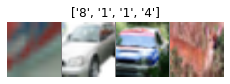

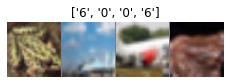

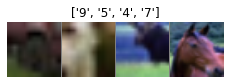

In [0]:
for i in range(4):
  batch_images(trainloader)

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [0]:
print(vgg) # gives the sequence in which vgg16 is working(features then average pool n then classifier)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [0]:
# because the classifier layer has final 1000 out_features but we have only 10 classes
# one way is to go read documentation & change out_features while object creation. below is a differetn method
final_in_features = vgg.classifier[6].in_features  # in features of final layer
mod_classifier = list(vgg.classifier.children())[:-1]    # all layers of classifier except final layer
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])  
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [0]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


#Training VGG

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [0]:
def evaluation(dataloader, model):  # func to calculate accuracy
  total, correct = 0, 0
  for data in dataloader:   #16 images in one loop. another shuffled 16 in next
    image, label = data
    image, label = image.to(device), label.to(device)  # store variables in gpu
    output = model(image)
    _, pred = torch.max(output.data, 1)  # torch.max returns a tuple with max value & it's index. We store index in pred
    total += label.size(0)  # to take number of labels in one batch
    correct += (pred == label).sum().item()
    return 100 * (correct/total)

In [0]:
vgg = vgg.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

Iteration: 0/3125, Loss : 2.19
Iteration: 100/3125, Loss : 1.99
Iteration: 200/3125, Loss : 1.96
Iteration: 300/3125, Loss : 2.11
Iteration: 400/3125, Loss : 1.98
Iteration: 500/3125, Loss : 1.86
Iteration: 600/3125, Loss : 2.01
Iteration: 700/3125, Loss : 2.31
Iteration: 800/3125, Loss : 1.67
Iteration: 900/3125, Loss : 2.16
Iteration: 1000/3125, Loss : 1.94
Iteration: 1100/3125, Loss : 1.80
Iteration: 1200/3125, Loss : 2.09
Iteration: 1300/3125, Loss : 1.87
Iteration: 1400/3125, Loss : 1.81
Iteration: 1500/3125, Loss : 2.29
Iteration: 1600/3125, Loss : 2.31
Iteration: 1700/3125, Loss : 1.80
Iteration: 1800/3125, Loss : 2.21
Iteration: 1900/3125, Loss : 1.79
Iteration: 2000/3125, Loss : 1.96
Iteration: 2100/3125, Loss : 1.75
Iteration: 2200/3125, Loss : 2.20
Iteration: 2300/3125, Loss : 2.38
Iteration: 2400/3125, Loss : 2.00
Iteration: 2500/3125, Loss : 1.61
Iteration: 2600/3125, Loss : 1.46
Iteration: 2700/3125, Loss : 1.50
Iteration: 2800/3125, Loss : 2.02
Iteration: 2900/3125, Loss

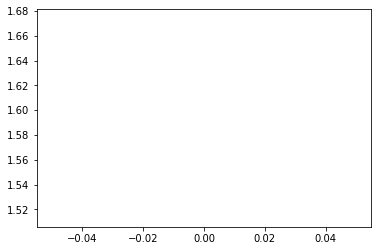

In [0]:
loss_epoch = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for i in range(max_epochs):

  for j, data in enumerate(trainloader, start=0):  # only 2 cols in dataset. So no need to split it. just use enumerate to access the required col
    inputs, labels = data                        # start 0 means start from index 0
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()

    output = vgg(inputs)
    loss = loss_func(output, labels)  # not writing torch.max() here because we need indices to compare & calculate accuracy. for loss original values required
    loss.backward()
    opt.step()  # updates weights & biases

    del inputs, output, labels
    torch.cuda.empty_cache()

    if j % 100 == 0:
      print('Iteration: %d/%d, Loss : %.2f' % (j, n_iters, loss.item()))
  loss_epoch.append(loss.item())

  print('Epoch : %d, Training Accuracy : %.3f, Test Accuracy : %.3f' % (i, evaluation(trainloader, vgg), evaluation(testloader, vgg)))

  plt.plot(loss_epoch)
  plt.show()
    

In [0]:
vgg = models.vgg16_bn(pretrained = True)  #pretrained parameters r also downloaded here

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:10<00:00, 54.7MB/s]


In [0]:
for params in vgg.parameters():
  params.requires_grad = False   # params of models should not be updated because it's pretrained n has good params

final_params = vgg.classifier[6].in_features   
vgg.classifier[6] = nn.Linear(final_params, num_classes) # adding new params to last layer which r equal to prev params but can be changed

In [0]:
for params in vgg.parameters():
  if params.requires_grad:
    print(params.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt =optim.SGD(vgg.parameters(), lr = 0.05)

In [0]:
import seaborn as sb
sb.set()

Iteration: 0/3125, Loss : 2.90
Iteration: 100/3125, Loss : 2.77
Iteration: 200/3125, Loss : 1.17
Iteration: 300/3125, Loss : 2.17
Iteration: 400/3125, Loss : 1.75
Iteration: 500/3125, Loss : 2.46
Iteration: 600/3125, Loss : 1.75
Iteration: 700/3125, Loss : 2.17
Iteration: 800/3125, Loss : 2.83
Iteration: 900/3125, Loss : 1.57
Iteration: 1000/3125, Loss : 1.34
Iteration: 1100/3125, Loss : 1.27
Iteration: 1200/3125, Loss : 1.80
Iteration: 1300/3125, Loss : 1.58
Iteration: 1400/3125, Loss : 2.69
Iteration: 1500/3125, Loss : 1.32
Iteration: 1600/3125, Loss : 2.91
Iteration: 1700/3125, Loss : 1.71
Iteration: 1800/3125, Loss : 2.06
Iteration: 1900/3125, Loss : 0.92
Iteration: 2000/3125, Loss : 1.64
Iteration: 2100/3125, Loss : 1.36
Iteration: 2200/3125, Loss : 2.00
Iteration: 2300/3125, Loss : 1.78
Iteration: 2400/3125, Loss : 2.08
Iteration: 2500/3125, Loss : 1.35
Iteration: 2600/3125, Loss : 2.02
Iteration: 2700/3125, Loss : 1.54
Iteration: 2800/3125, Loss : 2.16
Iteration: 2900/3125, Loss

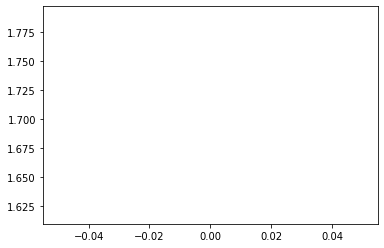

In [0]:
loss_epoch = []
max_epoch = 1


n_iters = np.ceil(50000/batch_size)

for i in tqdm_notebook(range(max_epoch), unit = 'epoch', total = max_epoch):
  for j, data in enumerate(trainloader, start = 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    output = vgg(inputs)
    loss = loss_func(output, labels)
    loss.backward()
    opt.step()

    del inputs, output, labels
    torch.cuda.empty_cache()

    if j % 100 == 0:
      print('Iteration: %d/%d, Loss : %.2f' % (j, n_iters, loss.item()))
  loss_epoch.append(loss.item())

  print('Epoch : %d, Training Accuracy : %.3f, Test Accuracy : %.3f' % (i, evaluation(trainloader, vgg), evaluation(testloader, vgg)))

  plt.plot(loss_epoch)
  plt.show()

In [0]:
import copy

Min Loss : 1.72
Iteration : 0/3125, Loss : 1.72
Min Loss : 1.66
Min Loss : 0.75
Iteration : 100/3125, Loss : 2.11
Iteration : 200/3125, Loss : 2.02
Iteration : 300/3125, Loss : 2.49
Iteration : 400/3125, Loss : 2.17
Iteration : 500/3125, Loss : 2.33
Min Loss : 0.53
Iteration : 600/3125, Loss : 2.51
Iteration : 700/3125, Loss : 2.14
Iteration : 800/3125, Loss : 1.36
Iteration : 900/3125, Loss : 3.02
Iteration : 1000/3125, Loss : 2.45
Iteration : 1100/3125, Loss : 2.24
Iteration : 1200/3125, Loss : 2.55
Iteration : 1300/3125, Loss : 1.09
Iteration : 1400/3125, Loss : 2.09
Iteration : 1500/3125, Loss : 1.18
Iteration : 1600/3125, Loss : 1.83
Iteration : 1700/3125, Loss : 2.07
Iteration : 1800/3125, Loss : 2.27
Min Loss : 0.52
Iteration : 1900/3125, Loss : 1.23
Min Loss : 0.51
Iteration : 2000/3125, Loss : 1.96
Iteration : 2100/3125, Loss : 2.27
Iteration : 2200/3125, Loss : 1.81
Iteration : 2300/3125, Loss : 2.31
Iteration : 2400/3125, Loss : 2.34
Iteration : 2500/3125, Loss : 1.92
Iterat

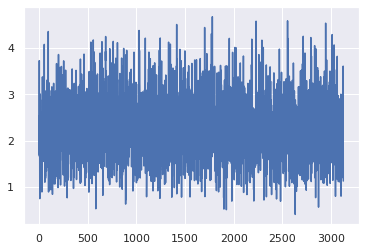

In [0]:
loss_epoch = []
max_epochs = 1

n_iterations = np.ceil(50000/batch_size)
min_loss = 1000

for i in range(max_epochs):
  for j,data in tqdm_notebook(enumerate(trainloader, start = 0), unit = 'Batches', total = n_iterations):
    inputs, label = data
    inputs, label = inputs.to(device), label.to(device)
    output = vgg(inputs)

    opt.zero_grad()
    loss = loss_func(output, label)
    loss.backward()
    opt.step()

    if min_loss > loss:
      min_loss = loss
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min Loss : %.2f' % min_loss)

    del inputs, output, label
    torch.cuda.empty_cache()

    if j % 100 == 0:
      print('Iteration : %d/%d, Loss : %.2f' % (j, n_iterations, loss.item()))

    loss_epoch.append(loss.item())
  
  print('Training Accuracy : %.2f, Testing Accuracy : %.2f' % (evaluation(trainloader, vgg), evaluation(testloader, vgg)))

  plt.plot(loss_epoch)
  plt.show()

#ResNet Model

In [0]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.5MB/s]


In [0]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for params in resnet.parameters():
  params.requires_grad = False

In [0]:
final_params = resnet.fc.in_features
resnet.fc = nn.Linear(final_params, num_classes)

In [0]:
resnet = resnet.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr = 0.01)

Min Loss : 2.46
Iteration : 0/3125, Loss : 2.46
Min Loss : 2.44
Min Loss : 2.03
Min Loss : 1.94
Min Loss : 1.92
Min Loss : 1.88
Min Loss : 1.82
Min Loss : 1.67
Min Loss : 1.67
Iteration : 100/3125, Loss : 2.02
Min Loss : 1.61
Min Loss : 1.54
Min Loss : 1.43
Min Loss : 1.39
Min Loss : 1.38
Min Loss : 1.36
Iteration : 200/3125, Loss : 1.42
Min Loss : 1.23
Min Loss : 1.18
Min Loss : 1.16
Iteration : 300/3125, Loss : 1.57
Min Loss : 1.13
Min Loss : 1.10
Iteration : 400/3125, Loss : 1.54
Min Loss : 1.05
Min Loss : 0.98
Min Loss : 0.93
Iteration : 500/3125, Loss : 1.62
Iteration : 600/3125, Loss : 2.03
Min Loss : 0.67
Iteration : 700/3125, Loss : 1.47
Iteration : 800/3125, Loss : 1.54
Iteration : 900/3125, Loss : 1.09
Iteration : 1000/3125, Loss : 1.62
Iteration : 1100/3125, Loss : 0.97
Min Loss : 0.64
Iteration : 1200/3125, Loss : 1.71
Iteration : 1300/3125, Loss : 1.62
Iteration : 1400/3125, Loss : 1.16
Iteration : 1500/3125, Loss : 1.18
Min Loss : 0.52
Iteration : 1600/3125, Loss : 1.32
I

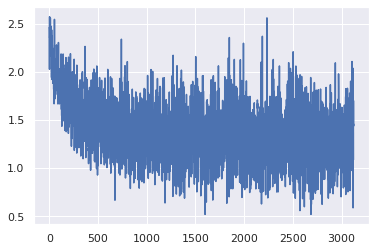

In [0]:
loss_epoch = []
max_epochs = 1

n_iterations = np.ceil(50000/batch_size)
min_loss = 1000

for i in range(max_epochs):
  for j,data in tqdm_notebook(enumerate(trainloader, start = 0), unit = 'Batches', total = n_iterations):
    inputs, label = data
    inputs, label = inputs.to(device), label.to(device)
    opt.zero_grad()
    output = resnet(inputs)

    loss = loss_func(output, label)
    loss.backward()
    opt.step()

    if min_loss > loss:
      min_loss = loss
      best_model = copy.deepcopy(resnet.state_dict())
      print('Min Loss : %.2f' % min_loss)

    del inputs, output, label
    torch.cuda.empty_cache()

    if j % 100 == 0:
      print('Iteration : %d/%d, Loss : %.2f' % (j, n_iterations, loss.item()))

    loss_epoch.append(loss.item())
  
  print('Training Accuracy : %.2f, Testing Accuracy : %.2f' % (evaluation(trainloader, resnet), evaluation(testloader, resnet)))

  plt.plot(loss_epoch)
  plt.show()

In [0]:
resnet.load_state_dict(best_model) 
print('Training Accuracy : %.2f, Testing Accuracy: %.2f' % (evaluation(trainloader, resnet), evaluation(testloader, resnet)))

Training Accuracy : 56.25, Testing Accuracy: 37.50


#Inception Model

In [0]:
inception = models.inception_v3(pretrained = True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 40.0MB/s] 


In [0]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for params in inception.parameters():
  params.requires_grad = False

In [0]:
aux_inputs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_inputs, num_classes)

In [0]:
final_params = inception.fc.in_features
inception.fc = nn.Linear(final_params, num_classes)

In [0]:
inception = inception.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.05)

In [0]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root = '/data', train = True, transform = train_transform, download = True)
testset = torchvision.datasets.CIFAR10(root = '/data', train = False, transform = test_transform, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [0]:
def evaluation_inception(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, label = data
    inputs, label = inputs.to(device), label.to(device)
    output, aux_output = model(inputs)
    _, pred = torch.max(output.data, 1)
    total += label.size(0)
    correct += (pred == label).sum().item()
    return 100 * correct/total

Min Loss : 3.03
Iteration : 0/3125, Loss : 3.03
Min Loss : 2.88
Min Loss : 2.68
Min Loss : 2.42
Min Loss : 2.35
Min Loss : 2.07
Min Loss : 2.06
Iteration : 100/3125, Loss : 2.78
Min Loss : 2.04
Min Loss : 1.70
Min Loss : 1.60
Iteration : 200/3125, Loss : 2.53
Iteration : 300/3125, Loss : 2.18
Min Loss : 1.35
Iteration : 400/3125, Loss : 3.32
Min Loss : 1.32
Min Loss : 1.31
Iteration : 500/3125, Loss : 1.94
Iteration : 600/3125, Loss : 1.57
Min Loss : 1.23
Iteration : 700/3125, Loss : 2.02
Min Loss : 0.98
Iteration : 800/3125, Loss : 1.56
Iteration : 900/3125, Loss : 2.36
Iteration : 1000/3125, Loss : 2.05
Iteration : 1100/3125, Loss : 1.83
Iteration : 1200/3125, Loss : 3.23
Iteration : 1300/3125, Loss : 2.29
Iteration : 1400/3125, Loss : 1.37
Iteration : 1500/3125, Loss : 2.54
Iteration : 1600/3125, Loss : 2.25
Min Loss : 0.96
Iteration : 1700/3125, Loss : 2.63
Iteration : 1800/3125, Loss : 2.23
Iteration : 1900/3125, Loss : 1.89
Iteration : 2000/3125, Loss : 2.03
Iteration : 2100/3125

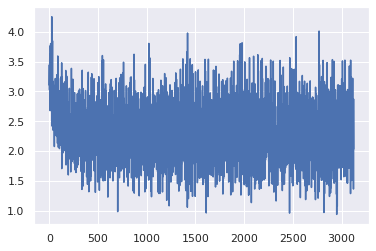

In [0]:
loss_epoch = []
num_iterations = np.ceil(50000/batch_size)

max_epoch = 1
min_loss = 1000
for i in range(max_epoch):
  for j, data in enumerate(trainloader, start = 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()

    output, aux_output = inception(inputs)
    loss = loss_func(output, labels) + 0.3 * loss_func(aux_output, labels)  # .3 is multiplied with aux loss to provide it less weightage
    loss.backward()
    opt.step()

    if min_loss > loss:
      min_loss = loss
      best_model = copy.deepcopy(inception.state_dict())
      print('Min Loss : %.2f'% min_loss)

    del inputs, labels, output
    torch.cuda.empty_cache()

    if j % 100 == 0:
      print('Iteration : %d/%d, Loss : %.2f'%(j, num_iterations, loss))
    
    loss_epoch.append(loss)
  plt.plot(loss_epoch)
  plt.show()

In [0]:
inception.load_state_dict(best_model)
print('Training Accuracy: %.2f, Testing Accuracy: %.2f'%(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception)))

Training Accuracy: 43.75, Testing Accuracy: 18.75
